## IttyBittyGPT 

Author: Antony Sikorski

With lots of help and inspiration from Misha Ivanitsky and his LLM & Interpretability course, and Karpathy's NanoGPT

In this notebook we walk through:
- Building the model
- Setting up the dataset (we use TinyStories)
- Training
- and a bit of Prompting and analysis

This is far from the most effective available implementation, and there are a number of things that could be improved, but I have found this to be the most effective way to learn how one works.

This file has everything you need for cooking up your own little transformer and training it on a chunk of the TinyStories dataset, but doing everything in one Jupyter Notebook is not best practice. The other files in the repo are a more modular and effective way of splitting this notebook up. 

Requirements: 

In [1]:
#!pip install -r requirements.txt

In [2]:
# necessary libraries 
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataclasses import dataclass
import json
from collections import Counter, defaultdict
from datasets import load_dataset

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.optim.lr_scheduler import StepLR
from jaxtyping import Int, Float
import tqdm
import transformers
import transformer_lens

from muutils.misc import shorten_numerical_to_str

c:\Python\Python_3_10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's check if you have a GPU on your computer that you can run this on. That could make this process significantly faster, but you could also run out of memory (Cuda Out Of Memory error). If you don't have torch with CUDA, don't worry about this, you can just use your CPU. 

In [3]:
if(torch.cuda.is_available() == True):
    print(torch.cuda.device_count())
    print(torch.cuda.get_device_name(0))

1
NVIDIA GeForce RTX 3060 Laptop GPU


I can use my laptop GPU, which is good news! Although I believe it only has 6 GB available, and only 1.5 of them will be available...

In [4]:
# necessary auto-reload for development on local machine
%load_ext autoreload
%autoreload 2

### Building the model

We first start off with a config class, which allows us to specify the params and size of our model:

In [5]:
@dataclass(kw_only=True)
class GPTConfig:
    """Here we configure the dimensions of
    our model. We'll set the defaults as the 
     dims from GPT2 """
    d_model: int = 768 # dimension of residual stream, the vectors it internally passes around 
    d_vocab: int = 50257 # defines the number of different tokens that can be represented as inputs (vocabulary size)
    n_context: int = 1024 # maximum sequence length (context window size)
    n_blocks: int = 12 # number of transformer blocks, frequently called n_layers but I don't like that 
    n_head: int = 12 # number of attention heads 
    head_bias: bool = True # whether to use bias in attention heads
    mlp_expansion: int = 4 # expansion factor in MLP (they go from small to big to small, this is how many times bigger the middle layer is)

    # model dimension must be divisible by number of heads
    @property
    def d_head(self):
        assert self.d_model % self.n_head == 0, f"'{self.d_model = }' must be divisible by '{self.n_head = }': {self.d_model} % {self.n_head} == {self.d_model % self.n_head}"
        return self.d_model // self.n_head
    
    @property
    def params_shapes(self) -> dict:
        return dict(
            token_embeddings=(self.d_vocab, self.d_model),
            positional_embeddings=(self.n_context, self.d_model),
            attention_weights=(
                self.n_blocks,
                4,
                self.d_model,
                self.d_model,
            ),
            attention_bias=(
                self.n_blocks,
                int(self.head_bias),
                self.d_model,
            ),
            mlp_weights=(
                self.n_blocks,
                2,
                self.d_model,
                self.d_model * self.mlp_expansion,
            ),
            mlp_bias=(
                self.n_blocks,
                self.mlp_expansion + 1,
                self.d_model,
            ),
            block_layernorms=(
                self.n_blocks,
                2,
                2,
                self.d_model,
            ),
            output_layernorm=(2, self.d_model),
            lm_head=(self.d_model, self.d_vocab),
        )
    
    @property
    def params_numel(self) -> dict:
        return {
            k: int(torch.tensor(v).prod())
            for k, v in self.params_shapes.items()
        }

    # will return the total number of parameters in the model
    @property
    def n_params(self) -> int:
        return sum([v for v in self.params_numel.values()])
    

Now we separately define the attention mechanism, which is the defining component of the transformer architecture, because it allows the model to preserve long range dependencies by learning what to pay *attention* to. 

It is essentially some matrix multiplications with a soft-max and a causal mask:

In [6]:
class AttentionHead(nn.Module):

    def __init__(self, config: GPTConfig):
        super().__init__()

        # store dimensions
        self.n_head: int = config.n_head
        self.d_model: int = config.d_model
        self.n_context: int = config.n_context

        # concatenating the outputs of the heads should give us d_model, but this check is done in GPTConfig
        self.d_head: int = config.d_head
        self.head_bias: bool = config.head_bias

        # magic coefficient for scaling the dot product of the query and key in the attention calculation
        self.sqrt_dim: float = 1.0 / math.sqrt(self.d_head)
    

        # key, query, value projections
        self.W_K: nn.Module = nn.Linear(self.d_model, self.d_head, bias = self.head_bias)
        self.W_Q: nn.Module = nn.Linear(self.d_model, self.d_head, bias = self.head_bias)
        self.W_V: nn.Module = nn.Linear(self.d_model, self.d_head, bias = self.head_bias)

        # causal mask to ensure that attention is only applied to the left in the input sequence
        # `register_buffer` means it's not a trainable parameter
        # the point here is to not allow the model to "look into the future" when making predictions
        self.register_buffer(
            "causal_mask", 
            torch.tril(
                torch.ones(config.n_context, config.n_context)
            )
            .view(1, 1, config.n_context, config.n_context)
        )


    def forward(self, x: Float[torch.Tensor, "batch n_ctx d_model"]) -> Float[torch.Tensor, "batch n_ctx d_head"]:
        assert x.ndim == 3, str(x.shape)
        B, n_ctx, d_model = x.shape # batch size, sequence length, embedding dimensionality (d_model)
        assert d_model == self.d_model, str(x.shape)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q: Float[torch.Tensor, "batch n_ctx d_head"] = self.W_Q(x)
        k: Float[torch.Tensor, "batch n_ctx d_head"] = self.W_K(x)
        v: Float[torch.Tensor, "batch n_ctx d_head"] = self.W_V(x)

        # self-attention
        att = (q @ k.transpose(-2, -1)) * self.sqrt_dim
        
        # autoregressive (causal) masking
        att = att.masked_fill(
            self.causal_mask[:,:n_ctx,:n_ctx] == 0, 
            float('-inf'),
        )

        # softmax
        att = F.softmax(att, dim=-1)

        # apply the self-attention to the values
        output = att @ v
        return output.view(B, n_ctx, self.d_head)

These are matrices that need to be learned, and we should check that the dims make sense: 

In [7]:
A: AttentionHead = AttentionHead(GPTConfig())
print(A)

AttentionHead(
  (W_K): Linear(in_features=768, out_features=64, bias=True)
  (W_Q): Linear(in_features=768, out_features=64, bias=True)
  (W_V): Linear(in_features=768, out_features=64, bias=True)
)


A visual demonstration of the causal mask. Although the plot you see is a matrix of $\{0, 1\}$ and not $\{-\infty, 0\}$, we use `masked_fill` in the  `.forward()` function to set the elements of `attn` to $-\infty$ where $M$ is 0.

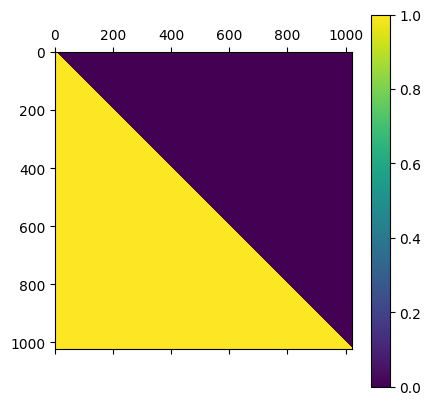

In [8]:
plt.matshow(A.causal_mask[0, 0].cpu().numpy())
plt.colorbar()
plt.show()

Now we add the multi-headed attention component. We compute the attention heads sequentially and then concatenate them, although it is very inefficient. Practical implementations do this all at once with one matrix multiplication, but the indexing for that is difficult to read and harder to learn from:

In [9]:
class MultiHeadedAttention(nn.Module):
	def __init__(self, config: GPTConfig):
		super().__init__()
		self.n_head: int = config.n_head
		self.d_head: int = config.d_model // config.n_head
		self.d_model: int = config.d_model

		# attention heads from previous class
		self.attention_heads: nn.ModuleList = nn.ModuleList([
			AttentionHead(config) 
			for _ in range(self.n_head)
		])

		# output projection
		self.W_O: nn.Module = nn.Linear(self.d_model, self.d_model)


	def forward(self, x: Float[torch.Tensor, "batch n_ctx d_model"]) -> Float[torch.Tensor, "batch n_ctx d_model"]:
		assert x.ndim == 3, str(x.shape)
		# apply all attention heads and concatenate their outputs
		# note: in reality, you would do this all in one tensor
		# we split the attention heads up to make it easier to understand
		att = torch.cat(
			[
				head(x) 
				for head in self.attention_heads
			],
			dim=-1,
		)
		assert len(att.shape) == 3, str(att.shape)

		# output projection
		output = self.W_O(att)
		assert output.shape == x.shape, str(output.shape)
		return output


The transformer is made from transformer blocks, which include multi-headed attention, an MLP, and some LayerNorms in between:

In [10]:
class TransformerBlock(nn.Module):
	def __init__(self, config: GPTConfig):
		super().__init__()

		# layernorm, attention, another layernorm, mlp
		self.ln_1: nn.Module = nn.LayerNorm(config.d_model)
		self.attention: nn.Module = MultiHeadedAttention(config)
		self.ln_2: nn.Module = nn.LayerNorm(config.d_model)
		self.mlp: nn.Module = nn.Sequential(
			nn.Linear(config.d_model, config.mlp_expansion * config.d_model),
			nn.GELU(),
			nn.Linear(config.mlp_expansion * config.d_model, config.d_model),
		)

	def forward(self, x: Float[torch.Tensor, "batch n_ctx d_model"]) -> Float[torch.Tensor, "batch n_ctx d_model"]:
		z = x + self.attention(self.ln_1(x))
		return z + self.mlp(self.ln_2(z))

Now we put it all together to form the itty-bitty GPT. The transformer decomposes a prompt into token embeddings and positional encodings, which then go through a series of transformer blocks (number defined by `n_blocks`). This then goes through a final LayerNorm, and a linear de-embedding. 

What we get at the end of this process is a probability distribution over tokens, and thus we need to sample from this with some randomness (`temperature`) and convert those tokens into words to get an output. 

We will just use the GPT2 tokenizer for the sake of simplicity. 

In [11]:
class GPT(nn.Module):
	def __init__(self, config: GPTConfig, tokenizer: transformers.PreTrainedTokenizer):
		super().__init__()

		self.config: GPTConfig = config
		self.tokenizer: transformers.PreTrainedTokenizer = tokenizer
		assert config.d_vocab >= tokenizer.vocab_size

		# token and positional embeddings
		self.token_embeddings: nn.Module = nn.Embedding(config.d_vocab, config.d_model)
		self.positional_embeddings: nn.Module = nn.Embedding(config.n_context, config.d_model)

		# transformer
		self.transformer_blocks: nn.ModuleList = nn.ModuleList([
			TransformerBlock(config) 
			for _ in range(config.n_blocks)
		])

		# language model head
		self.ln_f: nn.Module = nn.LayerNorm(config.d_model)
		self.lm_head: nn.Module = nn.Linear(config.d_model, config.d_vocab, bias=False)

	def forward(
			self, 
			x: Int[torch.Tensor, "batch n_ctx"],
			targets: Int[torch.Tensor, "batch n_ctx"]|None = None,
		) -> tuple:
		"""returns a tuple of (logits, loss) where loss=None if targets is None"""
		assert x.ndim == 2, str(x.shape)

		# calculate token and positional embeddings and sum them
		x_res: Float[torch.Tensor, "batch n_ctx d_model"] = self.token_embeddings(x) + self.positional_embeddings(torch.arange(x.size(1), device=x.device))

		assert x_res.ndim == 3, str(x.shape)

		# transformer blocks
		for i, block in enumerate(self.transformer_blocks):
			x_res = block(x_res)

		# language model head
		logits: Float[torch.Tensor, "batch n_ctx d_vocab"] = self.lm_head(self.ln_f(x_res))

		loss = None
		if targets is not None:
			loss = F.cross_entropy(
				logits.transpose(1, 2),
				targets,
				ignore_index=-1,
			)

		return logits, loss
	
	@torch.no_grad()
	def generate(
		self,
		prompt: str|list[int]|Int[torch.Tensor, "* n_ctx"],
		max_new_tokens: int = 128,
		temperature: float = 1.0,
	) -> str:

		# convert prompt to string and tensor versions
		prompt_str: str
		prompt_tensor: Int[torch.Tensor, "1 n_ctx"]
		if isinstance(prompt, str):
			prompt_str = prompt
			prompt_tensor = torch.tensor(self.tokenizer.encode(prompt_str), dtype=torch.long).unsqueeze(0) # add batch dim
		elif isinstance(prompt, list):
			prompt_str = self.tokenizer.decode(prompt)
			prompt_tensor = torch.tensor(prompt, dtype=torch.long).unsqueeze(0) # add batch dim
		elif isinstance(prompt, torch.Tensor):
			if prompt.ndim == 1:
				prompt = prompt.unsqueeze(0) # add batch dim
			assert prompt.ndim == 2

			prompt_str = self.tokenizer.decode(prompt[0].tolist())
			prompt_tensor = prompt
		else:
			raise ValueError(f"prompt must be a string, list of ints, or PyTorch tensor")
		
		# check tensor dims
		assert isinstance(prompt_str, str) 
		assert isinstance(prompt_tensor, torch.Tensor)
		assert prompt_tensor.ndim == 2 
		assert prompt_tensor.shape[0] == 1

		#  device
		prompt_tensor = prompt_tensor.to(self.device)

		# pad the prompt if necessary
		if prompt_tensor.shape[1] < self.config.n_context:
			prompt_tensor = F.pad(prompt_tensor, (0, self.config.n_context - prompt_tensor.shape[1]), value=self.tokenizer.pad_token_id)

		assert prompt_tensor.shape[1] == self.config.n_context

		# iterate until max_new_tokens is reached, or an end-of-sequence token is generated
		completions: list[int] = list()
		for _ in range(max_new_tokens):
			# truncate sequence to block size
			prompt_len: int = prompt_tensor.shape[1]
			if prompt_len > self.config.n_context:
				prompt_tensor = prompt_tensor[:, -self.config.n_context:]

			# forward the model to get the logits for the index in the sequence
			logits, _ = self(prompt_tensor)

			# pluck the logits at the final step and scale by desired temperature
			logits = logits[:, -1, :] / temperature

			# apply softmax to convert logits to (normalized) probabilities
			probs = F.softmax(logits, dim=-1)

			# sample from the distribution
			idx_next = torch.multinomial(probs, num_samples=1)

			# append sampled index to the running sequence and continue
			idx = torch.cat((prompt_tensor, idx_next), dim=1)

			# append the token to the running completions
			completions.append(int(idx_next[0, 0]))

			# check if end of sequence token is generated
			if idx_next == self.tokenizer.eos_token_id:
				break

		return self.tokenizer.decode(completions)

	@property
	def n_params(self) -> int:
		return sum(p.numel() for p in self.parameters())
	
	@property
	def device(self) -> torch.device:
		device_set: set[torch.device] = set(p.device for p in self.parameters())
		assert len(device_set) == 1, device_set
		return next(iter(device_set))

Let's print out a full model to take a look: 

In [12]:
test_cfg = GPTConfig()
print(f"{test_cfg.n_params = }")
test_model = GPT(test_cfg, transformers.GPT2Tokenizer.from_pretrained("gpt2"))
print(f"{test_model.n_params = }")

print(test_model)

test_cfg.n_params = 163009536
test_model.n_params = 163037184
GPT(
  (token_embeddings): Embedding(50257, 768)
  (positional_embeddings): Embedding(1024, 768)
  (transformer_blocks): ModuleList(
    (0): TransformerBlock(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attention): MultiHeadedAttention(
        (attention_heads): ModuleList(
          (0): AttentionHead(
            (W_K): Linear(in_features=768, out_features=64, bias=True)
            (W_Q): Linear(in_features=768, out_features=64, bias=True)
            (W_V): Linear(in_features=768, out_features=64, bias=True)
          )
          (1): AttentionHead(
            (W_K): Linear(in_features=768, out_features=64, bias=True)
            (W_Q): Linear(in_features=768, out_features=64, bias=True)
            (W_V): Linear(in_features=768, out_features=64, bias=True)
          )
          (2): AttentionHead(
            (W_K): Linear(in_features=768, out_features=64, bias=True)
            (W_Q): 

### Data

Let's use the TinyStories dataset, a well known dataset that gained fame when small yet still coherent models were trained on it. The dataset is made from a bunch of GPT generated children's stories, thus it does not have much diversity in content and should theoretically be pretty easy to learn. 

We only use a small chunk of the data for the sake of making training easy on a laptop. 

In [13]:
# grabbing the whole dataset
text_data = load_dataset("roneneldan/TinyStories")

#let's only use the training data
text_data = text_data["train"]

# and let's only use the first 1000 stories 
text_data = text_data[:100]

#what does a story look like? 
print("\n Sample story (story #8):")
text_data['text'][7]

Repo card metadata block was not found. Setting CardData to empty.



 Sample story (story #8):


'Once upon a time, in a peaceful town, there lived a little boy named Tim. Tim loved to run and play outside. One day, Tim saw a race in the park. He was excited and wanted to join the race.\n\nTim went to his friend, Sarah, and said, "Let\'s start the race!" Sarah smiled and said, "Yes, let\'s go!" They lined up with the other kids and waited for the race to begin. When they heard the word "Go!", they started running as fast as they could.\n\nTim and Sarah ran with all their speed, laughing and having fun. They could feel the wind in their hair as they raced to the finish line. In the end, Tim won the race and Sarah came in second. They were both so happy and proud of themselves. They celebrated with their friends and had a great day at the park.'

Okay now let's turn our dataset into a big long list of strings, and check how long it is (we want this to be small, millions or less): 

In [14]:
text_data = "\n\n".join(text_data['text'])
len(text_data)

76060

Aside: If you ever think this code isn't working, and want to do a sanity check, train the model on this dataset (which is just the letter "a" a bunch of times). When prompted with "a", your model output should feature tons of "a"s. You can use this as a sanity check (purely hypothetical, I definitely didn't do this):

In [15]:
# make a text dataset like text_data but filled strictly with "a" characters
# text_data_a = "a" * 10000

Now we define our TextDataset class, which is slightly inefficient because we have a fixed context size which we will stick with, and then we will trim off any data that isn't divisible by the context size. Ex: if we had 110 items in our dataset, and the context window is 25, it will chop off the last 10. Again, far from the best way, but it works and that's what we want. 

In [16]:
class TextDataset(Dataset):
	def __init__(
			self, 
			text: str, 
			tokenizer: transformers.PreTrainedTokenizer,
			n_context: int,
			ensure_n_context_match: bool = True,
		):
		# add 1 to n_context to account for the target token
		n_context += 1

		# tokenize the text
		tokenized_text: list[int] = tokenizer.encode(text)
		self.total_tokens: int = len(tokenized_text)

		# trim the last tokens to make sure the length is a multiple of n_context
		if ensure_n_context_match:
			tokenized_text = tokenized_text[:-(len(tokenized_text) % n_context)]
			self.total_tokens = len(tokenized_text)

		# split the text into examples of length n_context
		# this means that text will often start in the middle of a sentence
		# in reality, we might want to do this a bit smarter
		self.examples: list[list[int]] = [
			tokenized_text[i:i+n_context] 
			for i in range(0, len(tokenized_text), n_context)
		]

	def __len__(self) -> int:
		return len(self.examples)
	
	def __getitem__(self, i: int) -> Float[torch.Tensor, "n_ctx"]:
		return torch.tensor(self.examples[i], dtype=torch.long, device = 'cpu')
	
	def example_lengths(self) -> Counter[int]:
		return Counter(len(ex) for ex in self.examples)

### Training 

Here we train the model! First, we define our training loop. Our dataset is saved on the CPU, but everything else will be on GPU. We will move our batches from CPU to GPU. This slows things down, but is worth the extra compute because it enables us to use more data.  

In [17]:
def train(
	model: GPT,
	text: str,
	optimizer: torch.optim.Optimizer,
	scheduler: torch.optim.lr_scheduler._LRScheduler,
	device: torch.device = ("cuda" if torch.cuda.is_available() else "cpu"),
	batch_size: int = 8,
	max_batches: int|None = None,
	print_interval: int = 100,
	epochs: int = 1,
) -> tuple[GPT, list[dict]]:
	
	# move model to device
	print(f"moving model to device: {device}")
	model.to(device)
	
	# set up data
	print(f"setting up dataset from text of length {len(text)}")
	dataset: TextDataset = TextDataset(
		text=text, 
		tokenizer=model.tokenizer, 
		n_context=model.config.n_context,
	)
	print(f"\tset up dataset with {len(dataset)} examples, example lengths: {dataset.example_lengths()}")

	print(f"setting up dataloader from {len(dataset)} examples")
	dataloader: DataLoader = DataLoader(
		dataset, 
		batch_size=batch_size, 
		shuffle=True,
	)
	print(f"\tset up dataloader with {len(dataloader)} batches of size {batch_size}")

	# set up training loop
	print("training...")
	training_records: list[dict] = list()
	model.train()

	for epoch in range(epochs):
		print(f"Epoch {epoch + 1}/{epochs}\n")
		i: int; batch: Float[torch.Tensor, "batch n_ctx"]
		for i, batch in tqdm.tqdm(
			enumerate(dataloader),
			total=len(dataloader),
			desc="Training",
		):
			# move batch to device 
			# you have most likely saved the dataset to the cpu, so you need to move it to the gpu
			batch = batch.to(device)
			
			# break if we've reached the maximum number of batches
			if max_batches is not None and i > max_batches:
				break

			# forward pass
			logits, loss = model(
				batch[:, :-1],
				targets=batch[:, 1:], # the targets are just the input, offset by one
			)

			# backward pass
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()

			# record progress
			training_records.append({
				"batch": i,
				"loss": loss.item(),
			})

			if i % print_interval == 0:
				print(f"Batch {i}, Loss: {loss.item()}\n")

		scheduler.step()
    	#print(f"Updated learning rate to: {optimizer.param_groups[0]['lr']}")

	return model, training_records

Now let's configure (define params for) our own model (which will be tiny) and do some setup before we train it: 

In [18]:
# using the GPT2 tokenizer, and making sure it has the same vocab size as the model
TOKENIZER: transformers.PreTrainedTokenizer = transformers.AutoTokenizer.from_pretrained("gpt2")
print(f"{TOKENIZER.vocab_size = } \n")


# set up a config for a small model
CONFIG: GPTConfig = GPTConfig(
	d_model=8,
	d_vocab=50257,
	n_context=128,
	n_blocks=2,
	n_head=4,
)

# not the most necessary check but it felt good to do
assert(TOKENIZER.vocab_size == GPTConfig().d_vocab)

# initialize the model
MODEL: GPT = GPT(CONFIG, TOKENIZER)

#two ways of printing number of model params
print("Muutils rounded model params: ")
print(f"MODEL.n_params = {shorten_numerical_to_str(MODEL.n_params)} \n")
print("Full model params: ")
print(f"MODEL.n_params = {MODEL.n_params}")

# choice of optimizer
OPTIMIZER: torch.optim.Optimizer = torch.optim.AdamW(MODEL.parameters(), lr=1e-1)
#OPTIMIZER: torch.optim.Optimizer = torch.optim.SGD(MODEL.parameters(), lr=1e-1)
# Initialize the learning rate scheduler
SCHEDULER: StepLR = StepLR(OPTIMIZER, step_size=30, gamma=0.1)

TOKENIZER.vocab_size = 50257 

Muutils rounded model params: 
MODEL.n_params = 807K 

Full model params: 
MODEL.n_params = 806896


Let's train the model! 

In [19]:
MODEL_TRAINED, training_history = train(
	model=MODEL,
	text=text_data,
	optimizer=OPTIMIZER,
    scheduler = SCHEDULER,
	device=("cuda" if torch.cuda.is_available() else "cpu"),
	batch_size=32,
	max_batches=None,
	print_interval=100,
	epochs=10,
)


moving model to device: cuda


Token indices sequence length is longer than the specified maximum sequence length for this model (18985 > 1024). Running this sequence through the model will result in indexing errors


setting up dataset from text of length 76060
	set up dataset with 147 examples, example lengths: Counter({129: 147})
setting up dataloader from 147 examples
	set up dataloader with 5 batches of size 32
training...
Epoch 1/10



Training:  40%|████      | 2/5 [00:05<00:06,  2.18s/it]

Batch 0, Loss: 10.94760799407959



Training: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Epoch 2/10



Training:  20%|██        | 1/5 [00:00<00:00,  6.61it/s]

Batch 0, Loss: 6.412278652191162



Training: 100%|██████████| 5/5 [00:00<00:00,  6.98it/s]


Epoch 3/10



Training:  20%|██        | 1/5 [00:00<00:00,  6.76it/s]

Batch 0, Loss: 5.863760471343994



Training: 100%|██████████| 5/5 [00:00<00:00,  6.76it/s]


Epoch 4/10



Training:  20%|██        | 1/5 [00:00<00:00,  6.07it/s]

Batch 0, Loss: 5.572959899902344



Training: 100%|██████████| 5/5 [00:00<00:00,  6.73it/s]


Epoch 5/10



Training:  20%|██        | 1/5 [00:00<00:00,  6.93it/s]

Batch 0, Loss: 5.32457160949707



Training: 100%|██████████| 5/5 [00:00<00:00,  6.97it/s]


Epoch 6/10



Training:  20%|██        | 1/5 [00:00<00:00,  6.55it/s]

Batch 0, Loss: 5.051607608795166



Training: 100%|██████████| 5/5 [00:00<00:00,  6.53it/s]


Epoch 7/10



Training:  20%|██        | 1/5 [00:00<00:00,  6.86it/s]

Batch 0, Loss: 4.910337924957275



Training: 100%|██████████| 5/5 [00:00<00:00,  7.08it/s]


Epoch 8/10



Training:  20%|██        | 1/5 [00:00<00:00,  6.24it/s]

Batch 0, Loss: 4.647175312042236



Training: 100%|██████████| 5/5 [00:00<00:00,  6.72it/s]


Epoch 9/10



Training:  20%|██        | 1/5 [00:00<00:00,  6.62it/s]

Batch 0, Loss: 4.275420188903809



Training: 100%|██████████| 5/5 [00:00<00:00,  6.43it/s]


Epoch 10/10



Training:  20%|██        | 1/5 [00:00<00:00,  6.47it/s]

Batch 0, Loss: 4.257217884063721



Training: 100%|██████████| 5/5 [00:00<00:00,  6.47it/s]


Now we save our trained model: 

In [24]:
torch.save(MODEL_TRAINED, "C:/Users/anton/Desktop/Mines/DSCI _575_AdvML/Programming_Project/saved_models/tutorial_model.pt")

### Analysis of Model

First, let's take a quick look at our loss: 

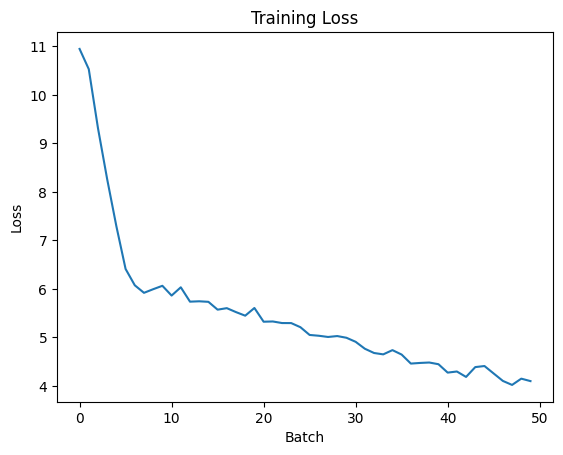

In [25]:
#plot loss over epochs
losses = [record["loss"] for record in training_history]
plt.plot(losses)
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

It appears that it shakily decreased throughout the training run. Now let's test out some prompts, and see what our model gives us. 

In [26]:
print(MODEL_TRAINED.generate("Once upon a time, Tim climbed"))

 Soeddy  It

 spot
  Then
 He




 She He Emily  They She They When They
 He They hands This
 The InThe case But It What
 They SheMary
sola
 With ride One They  His Theywed car There
 The She


 She Lily car



 She It They The As� Nora Ited
 He

 The He


  
- But But
 She
 SheBut She eye  toys He That He 


 Oneeddy Inside He It dress One That The She rabbit course
 He She Nora She



Not great, but could be much worse.. We'll come back to this and make it actually work. I'm pretty sure the model we are using is just a bit less than the smallest TinyStories model (1M), so I assume we can pull this off. 